# Metodos no lineales para reduccion de la dimensionalidad

En esta experimentacion nos proponemos experimentar con metodos alternativos de preprocesamiento de los datos para reducir su dimension. Consideraremos los siguientes metodos (EXPLICARLOS EN EL INFORME)

-tsne sklearn.manifold: Manifold Learning? (explorar)
-lda
-autoencoders


Una de las hipotesis que obviamente tengo es que las relaciones entre pixeles y la clase no necesariamente es lineal (y lo mas probable es que no lo sea)

A PARTIR DE ACA NUESTRA REFERENCIA 'OPTIMA' COMO ALGORITMO DE PCA Y KNN VA A SER EL DE ALFA 15 Y K 15

A partir de ahora solo compararemos accuracy y tiempo de ejecucion (recordemos que el resto de las metricas eran practicamente iguales para este dataset).

- Classify images with TPUs in [**Petals to the Metal**](https://www.kaggle.com/c/tpu-getting-started)
- Create art with GANs in [**I'm Something of a Painter Myself**](https://www.kaggle.com/c/gan-getting-started)
- Classify Tweets in [**Real or Not? NLP with Disaster Tweets**](https://www.kaggle.com/c/nlp-getting-started)
- Detect contradiction and entailment in [**Contradictory, My Dear Watson**](https://www.kaggle.com/c/contradictory-my-dear-watson)

## t-Sne

### Prueba con parametros por defecto

En esta seccion vamos a tantear un poco el uso del algoritmo de reduccion de la dimensionalidad t-SNE, para ganar intuicion y observar potenciales beneficios. Inicialmente, por una mala comprension del algoritmo, pense que se usaba para reducir la dimensionalidad del set de entrenamiento y que este finalmente sea menos costoso por procesar informacion redundante, pero en realidad parece ser que t-sne solo se usa para visualizar la informacion. La idea es ver que tan bien puede el algoritmo clasificar los datos de manera no supervisada. 
Previamente al uso de t-SNE, se aplica PCA para reducir el tiempo de entrenamiento del algoritmo ya que este es muy costoso.

Luego de la primera visualizacion, trataremos de usar el algoritmo para ver si se puede usar para mejorar la presicion de kNN para clasificar fotos.

In [1]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
df = pd.read_csv("./data/fashion-mnist_train.csv")
df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X = df.iloc[:,1:]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X,y)

#### Paso de reduccion

In [6]:


t0 = time.time()
pca = PCA(15)
pca.fit(X)
X = pca.transform(X)
#X_test = pca.transform(X_test)
t1 = time.time()
print("PCA time: ", t1-t0, "\n")
dim_red = TSNE()
X_lowDim = dim_red.fit_transform(X)
t2 = time.time()

print("t-SNE time: ",t2-t1)

PCA time:  0.059745073318481445 

t-SNE time:  252.1874942779541


#### Nota:
Inicialmente tratamos de bajar la dimensionalidad de un saque pero tarda mucho y el algoritmo se pone muy pesado. Vamos a aplicar PCA con alfa = 15. El tiempo de ejecucion no fue medido pero al momento de escribir esto ya van mas de 5 minutos.

In [8]:
import seaborn as sns

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

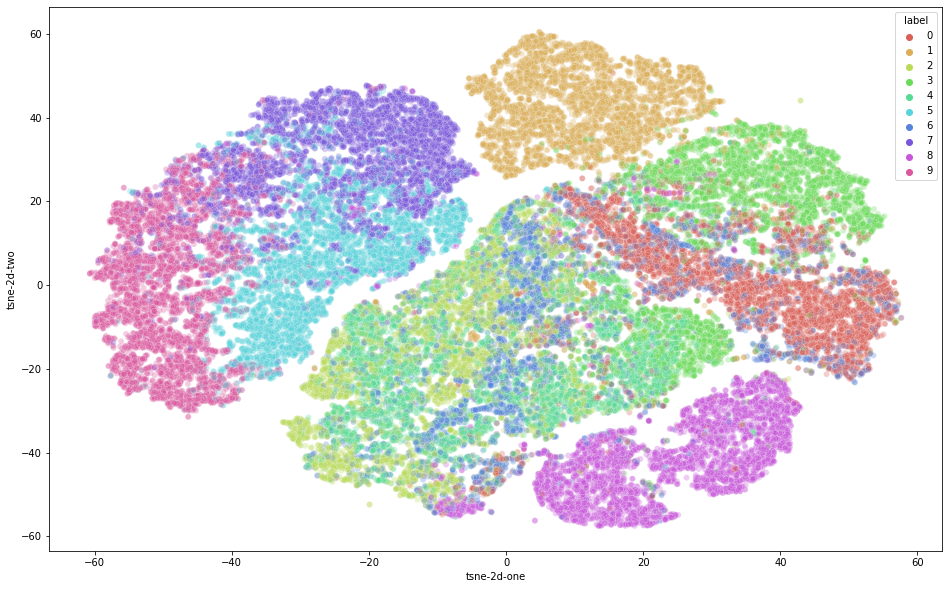

In [17]:

df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = X_lowDim[:,0]
df_subset['tsne-2d-two'] = X_lowDim[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=y,
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

### Observaciones iniciales

Fabuloso como un algoritmo no supervisado puede hacer clusteres tan similares a las categorias verdaderas (visualmente.) Notese la efectividad al clasificar 1 y 8 principalmente. Tambien 9, 5 y 7 parecen estar relativamente bien separados. Sin embargo, en el resto de los numeros parece haber mucha confusion.

## UMAP  

A diferencia de t-SNE y similarmente a PCA, este algoritmo si esta diseniado para mas que para visualizar datos... Pues nos permite hacer fit y transform por separado. 